In [73]:
%pip install h5py numpy matplotlib pandas
%pip install optuna


import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

plt.style.use('default')   


Note: you may need to restart the kernel to use updated packages.


## Data Loading

- **Dataset:** N-CMAPSS (Option to combine 3 but only uses 006 for this)
- **Goal:** Build a unified dataframe for modeling

**Steps**
1. Load the HDF5 file and concatenate feature blocks
2. Add target lable 
3. Create a unique ID 
4. Basic print

In [74]:
BASE_DIR = '../data_set/'

dataset_files = [
    #"N-CMAPSS_DS01-005.h5",
    "N-CMAPSS_DS02-006.h5",
    #"N-CMAPSS_DS03-012.h5",
]

def decode(byte_array):
    return [x.decode('utf-8') for x in byte_array]

def load_df(h5path, tag = None):
    hdf = h5py.File(h5path, 'r')
    
    A_var = decode(hdf["A_var"])
    T_var = decode(hdf["T_var"])
    W_var = decode(hdf["W_var"])
    Xs_var = decode(hdf["X_s_var"]) 

    A_dev = hdf["A_dev"][:]
    T_dev = hdf["T_dev"][:]
    W_dev = hdf["W_dev"][:]
    Xs_dev = hdf["X_s_dev"][:]
    Y_dev = hdf["Y_dev"][:]

    df = pd.concat([
        pd.DataFrame(A_dev, columns=A_var),
        pd.DataFrame(W_dev, columns=W_var),
        pd.DataFrame(Xs_dev, columns=Xs_var),
        pd.DataFrame(T_dev, columns=T_var)
    ], axis=1)

    df["RUL"] = Y_dev[:, 0]
    df["unit"] = df["unit"].astype('int')
    if tag is None:
        tag = os.path.basename(h5path).replace('.h5', '')

    df["dataset"] = tag
    df["engine_id"] = df["dataset"] + "_u" + df["unit"].astype(str)
    hdf.close()
    return df

dev_list = []
for file in dataset_files:
    h5path = os.path.join(BASE_DIR, file)
    tag = file.split(".h5")[0]
    df_i = load_df(h5path, tag=file.replace('.h5',''))

    engines = sorted(df_i["engine_id"].unique())
    print(f"Dataset: {tag}")
    print("Number of rows: ", len(df_i))
    print("Number of engines: ", len(engines))
    
    cyclestats = df_i.groupby("engine_id")["cycle"].agg(['min', 'max'])
    print("Cycles per engine (min/max):")
    print(cyclestats.describe())
    print("\n")
    dev_list.append(df_i)
    
df_dev = pd.concat(dev_list, ignore_index=True)
df_dev = df_dev.reset_index(drop=True).copy()
df_dev["_t_global"]   = df_dev.groupby("engine_id").cumcount()
df_dev["_t_in_cycle"] = df_dev.groupby(["engine_id", "cycle"]).cumcount()

print("\ndf_Dev shape:", df_dev.shape)
print("Total unique engines: ", df_dev["engine_id"].nunique())
print("Units: ", sorted(df_dev["unit"].unique()))

print("\nCycles per unit (min/max):")
cyclestats = df_dev.groupby("unit")["cycle"].agg(['min', 'max'])

df_dev.describe().T.head(15)
df_dev 



Dataset: N-CMAPSS_DS02-006
Number of rows:  5263447
Number of engines:  6
Cycles per engine (min/max):
       min        max
count  6.0   6.000000
mean   1.0  74.333333
std    0.0   9.831921
min    1.0  63.000000
25%    1.0  67.250000
50%    1.0  73.000000
75%    1.0  80.250000
max    1.0  89.000000



df_Dev shape: (5263447, 37)
Total unique engines:  6
Units:  [np.int64(2), np.int64(5), np.int64(10), np.int64(16), np.int64(18), np.int64(20)]

Cycles per unit (min/max):


,unit,cycle,Fc,hs,alt,Mach,TRA,T2,T24,T30,...,HPC_flow_mod,HPT_eff_mod,HPT_flow_mod,LPT_eff_mod,LPT_flow_mod,RUL,dataset,engine_id,_t_global,_t_in_cycle
0,2,1.0,3.0,1.0,10005.0,0.448497,76.903748,502.420918,600.148034,1438.498187,...,0.0,-0.000638,0.0,0.000000,0.000000,74,N-CMAPSS_DS02-006,N-CMAPSS_DS02-006_u2,0,0
1,2,1.0,3.0,1.0,10013.0,0.447741,76.903748,502.326114,600.055894,1438.350208,...,0.0,-0.000638,0.0,0.000000,0.000000,74,N-CMAPSS_DS02-006,N-CMAPSS_DS02-006_u2,1,1
2,2,1.0,3.0,1.0,10017.0,0.448938,77.079529,502.416067,600.210756,1439.109101,...,0.0,-0.000638,0.0,0.000000,0.000000,74,N-CMAPSS_DS02-006,N-CMAPSS_DS02-006_u2,2,2
3,2,1.0,3.0,1.0,10024.0,0.449883,77.079529,502.469893,600.369717,1439.240230,...,0.0,-0.000638,0.0,0.000000,0.000000,74,N-CMAPSS_DS02-006,N-CMAPSS_DS02-006_u2,3,3
4,2,1.0,3.0,1.0,10031.0,0.449379,77.079529,502.401271,600.298227,1439.064004,...,0.0,-0.000638,0.0,0.000000,0.000000,74,N-CMAPSS_DS02-006,N-CMAPSS_DS02-006_u2,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5263442,20,66.0,3.0,0.0,10036.0,0.502866,38.407928,507.301734,567.846845,1286.087972,...,0.0,-0.007693,0.0,-0.023184,-0.006428,0,N-CMAPSS_DS02-006,N-CMAPSS_DS02-006_u20,768155,9566
5263443,20,66.0,3.0,0.0,10026.0,0.502551,38.583710,507.308340,567.942650,1287.089618,...,0.0,-0.007693,0.0,-0.023184,-0.006428,0,N-CMAPSS_DS02-006,N-CMAPSS_DS02-006_u20,768156,9567
5263444,20,66.0,3.0,0.0,10020.0,0.502866,38.847378,507.361541,568.241901,1288.541567,...,0.0,-0.007693,0.0,-0.023184,-0.006428,0,N-CMAPSS_DS02-006,N-CMAPSS_DS02-006_u20,768157,9568
5263445,20,66.0,3.0,0.0,10012.0,0.502740,38.935268,507.380028,568.462600,1288.872381,...,0.0,-0.007693,0.0,-0.023184,-0.006428,0,N-CMAPSS_DS02-006,N-CMAPSS_DS02-006_u20,768158,9569


## EDA

This section is related to generating summary plots to understand the data and the distribution of it's variables

**Setup**
- Select one engine (`unit_id`) and a single flight cycle (`cycle_id`)
- Variables
    - **Sensors** `T24, T30, T48, T50`
    - **Conditions** `alt, Mach, TRA, T2`

**Figures**
1. **Overview**
    - Histogram of RUL values 
    - Bar chart of max cycles per engine
    - Histogram of altitude distribution 
2. **1Hz samples**
    - Conditions over global time at one engine
    -  Conditions within a cycle
3. **Sensors**
    - Sensors over time for one engine
    - Sensor within a cycle

4. **RUL Trajectory**
    - RUL vs cycle for one engine

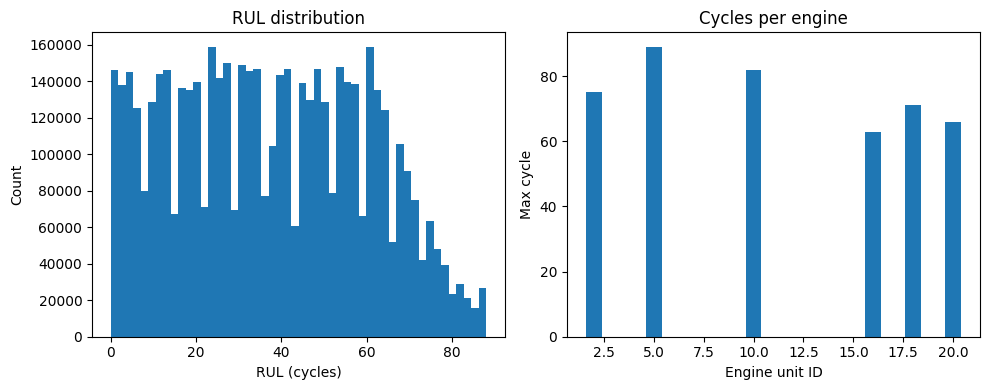

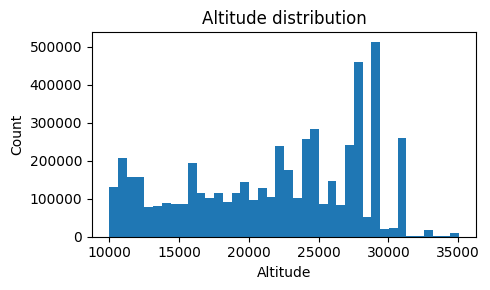

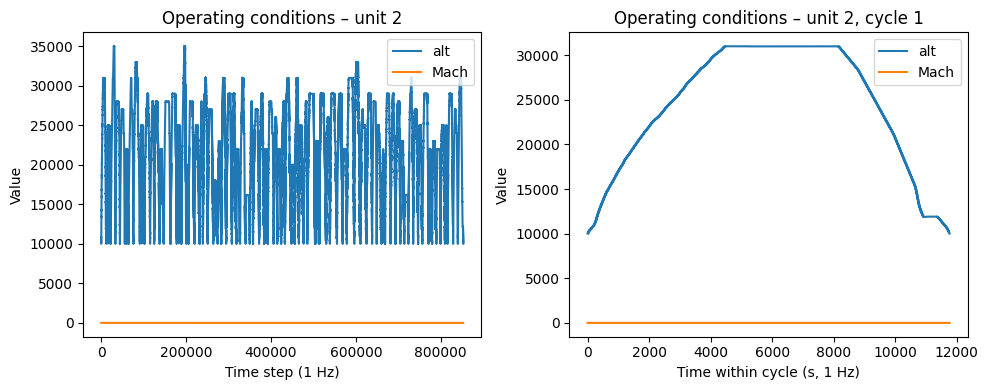

C:\Users\vaibh\AppData\Local\Temp\ipykernel_50484\2816866251.py:81: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\vaibh\miniconda3\envs\cs178\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


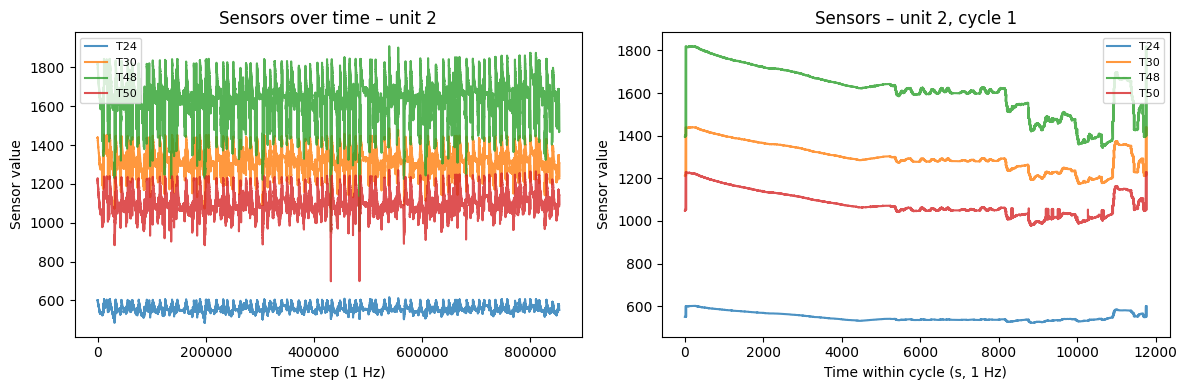

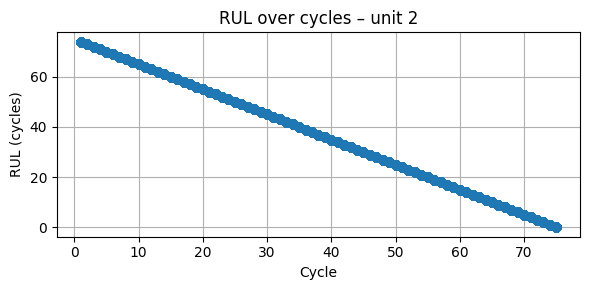

In [75]:
import numpy as np
import matplotlib.pyplot as plt

unit_id  = 2 
cycle_id = 1
sensor_cols = ["T24", "T30", "T48", "T50"]
op_cols     = ["alt", "Mach", "TRA", "T2"]

df_unit = df_dev[df_dev["unit"] == unit_id].copy().sort_values(["cycle"])
df_unit["time_idx"] = np.arange(len(df_unit))

df_uc = df_dev[(df_dev["unit"] == unit_id) & (df_dev["cycle"] == cycle_id)].copy()
df_uc = df_uc.sort_values(df_uc.columns[0])
df_uc["t_in_cycle"] = np.arange(len(df_uc))


fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# 1a) RUL distribution
axes[0].hist(df_dev["RUL"], bins=50)
axes[0].set_xlabel("RUL (cycles)")
axes[0].set_ylabel("Count")
axes[0].set_title("RUL distribution")

# 1b) Cycles per engine
cycles_per_unit = df_dev.groupby("unit")["cycle"].max()
axes[1].bar(cycles_per_unit.index, cycles_per_unit.values)
axes[1].set_xlabel("Engine unit ID")
axes[1].set_ylabel("Max cycle")
axes[1].set_title("Cycles per engine")

plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 3))
plt.hist(df_dev["alt"], bins=40)
plt.xlabel("Altitude")
plt.ylabel("Count")
plt.title("Altitude distribution")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# 2a) Operating conditions over global time (1 Hz) for one engine
axes[0].plot(df_unit["time_idx"], df_unit["alt"], label="alt")
axes[0].plot(df_unit["time_idx"], df_unit["Mach"], label="Mach")
axes[0].set_xlabel("Time step (1 Hz)")
axes[0].set_ylabel("Value")
axes[0].set_title(f"Operating conditions – unit {unit_id}")
axes[0].legend()

# 2b) Operating conditions within a single cycle (1 Hz)
axes[1].plot(df_uc["t_in_cycle"], df_uc["alt"], label="alt")
axes[1].plot(df_uc["t_in_cycle"], df_uc["Mach"], label="Mach")
axes[1].set_xlabel("Time within cycle (s, 1 Hz)")
axes[1].set_ylabel("Value")
axes[1].set_title(f"Operating conditions – unit {unit_id}, cycle {cycle_id}")
axes[1].legend()

plt.tight_layout()
plt.show()
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 3a) Sensors vs global time (same engine)
for col in sensor_cols:
    axes[0].plot(df_unit["time_idx"], df_unit[col], label=col, alpha=0.8)
axes[0].set_xlabel("Time step (1 Hz)")
axes[0].set_ylabel("Sensor value")
axes[0].set_title(f"Sensors over time – unit {unit_id}")
axes[0].legend(fontsize=8)

# 3b) Sensors within a single cycle
for col in sensor_cols:
    axes[1].plot(df_uc["t_in_cycle"], df_uc[col], label=col, alpha=0.8)
axes[1].set_xlabel("Time within cycle (s, 1 Hz)")
axes[1].set_ylabel("Sensor value")
axes[1].set_title(f"Sensors – unit {unit_id}, cycle {cycle_id}")
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.show()


plt.figure(figsize=(6, 3))
plt.plot(df_unit["cycle"], df_unit["RUL"], marker="o", linewidth=1)
plt.xlabel("Cycle")
plt.ylabel("RUL (cycles)")
plt.title(f"RUL over cycles – unit {unit_id}")
plt.grid(True)
plt.tight_layout()
plt.show()

## Train, validation, and test splits 

Splits data by **engine** using engine id to ensure all timesteps from an engine appear in only one train/val/test

**Procedure**
- Collect unique id
- Split engine into:
    - **Train:** 70%
    - **Validation** 15%
    - **test** 15%
- Create `train_df`, `val_df`, `test_df`

**Output**
- Prints # unique engines in each split 

In [76]:
from sklearn.model_selection import train_test_split

#10% train
#10% test

engines = sorted(df_dev["engine_id"].unique())
train_ids, temp_ids = train_test_split(engines, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

train_df = df_dev[df_dev["engine_id"].isin(train_ids)].reset_index(drop=True)
val_df   = df_dev[df_dev["engine_id"].isin(val_ids)].reset_index(drop=True)
test_df  = df_dev[df_dev["engine_id"].isin(test_ids)].reset_index(drop=True)

print("Train engines:", train_df["engine_id"].nunique())
print("Validation engines:", val_df["engine_id"].nunique())
print("Test engines:", test_df["engine_id"].nunique())

Train engines: 4
Validation engines: 1
Test engines: 1


## Feature Corellation 

This step measures how strongly features are correlated with **RUL**

**Functionality**
- Starts from a number of handpicked conditions
- Computes the pearson correlation between feature and `RUL`
- Story features by absolute correlation magnitude to get strongest relationships

**Output**
- ``corr_w_rul` : ranked list of feature-rul corrs for initial feature selection

In [77]:
cols = [
    "alt", "Mach", "TRA", "T2",
    "Wf", "Nf", "Nc",
    "T24", "T30", "T48", "T50",
    "P15", "P2", "P21", "Ps30", "P40", "P50"
]

candidate_cols = [c for c in cols if c in train_df.columns]

print("Candidate columns for modeling:", candidate_cols)

corr_w_rul = train_df[candidate_cols + ["RUL"]].corr(numeric_only=True)["RUL"].drop("RUL")
corr_w_rul = corr_w_rul.reindex(corr_w_rul.abs().sort_values(ascending=False).index)

corr_w_rul

Candidate columns for modeling: ['alt', 'Mach', 'TRA', 'T2', 'Wf', 'Nf', 'Nc', 'T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'Ps30', 'P40', 'P50']


T50    -0.137255
T48    -0.084904
Wf     -0.025938
T24    -0.016355
Nc      0.012982
T2     -0.005249
P50    -0.004461
Mach   -0.004112
P21    -0.003817
P15    -0.003817
TRA    -0.003104
Nf     -0.003068
P2     -0.002561
Ps30   -0.002309
alt     0.001873
P40    -0.001105
T30    -0.000756
Name: RUL, dtype: float64

## Feature Importance 

Uses a **random forest regressor** to estimate feature importance in non-linear setting

**Functionality**
- `Xall`: candidate features
- `Yall`: target label
` Picks a small sample of data for speeding up calculation
- Trains random forest regressor for a quick model and sorts the feature importances to see what features model relies on

**Output**
- ``modelimportances` : ranked list of feature-rul importances for initial feature selection

In [78]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

Xall = train_df[candidate_cols]
yall = train_df["RUL"]

fraction = 0.05
if fraction < 1.0:
    Xsample = Xall.sample(frac=fraction, random_state=42)
    ysample = yall.loc[Xsample.index]
else:
    Xsample = Xall
    ysample = yall

model = RandomForestRegressor(n_estimators=50, max_depth=8, n_jobs=-1, random_state=42)
model.fit(Xsample, ysample)
modelimportances = pd.Series(model.feature_importances_, index=candidate_cols)
modelimportances = modelimportances.sort_values(ascending=False)

print("Random forest importances")
display(modelimportances)

Random forest importances


T50     0.354871
Nc      0.239572
P40     0.125915
Ps30    0.099872
Mach    0.048189
Wf      0.043953
T48     0.030139
Nf      0.016820
TRA     0.015267
T2      0.007392
alt     0.005314
T24     0.004718
P50     0.004193
P2      0.001915
P21     0.000770
T30     0.000645
P15     0.000456
dtype: float64

In [79]:
k = 10
topcorr = corr_w_rul.abs().head(k).index.tolist()
print("Top by correlation:", topcorr)

topimp = modelimportances.head(k).index.tolist()
print("Top by importance:", topimp)

selected = sorted(set(topcorr) | set(topimp))
print("Selected features for modeling:", selected)

feature_cols = selected

Top by correlation: ['T50', 'T48', 'Wf', 'T24', 'Nc', 'T2', 'P50', 'Mach', 'P21', 'P15']
Top by importance: ['T50', 'Nc', 'P40', 'Ps30', 'Mach', 'Wf', 'T48', 'Nf', 'TRA', 'T2']
Selected features for modeling: ['Mach', 'Nc', 'Nf', 'P15', 'P21', 'P40', 'P50', 'Ps30', 'T2', 'T24', 'T48', 'T50', 'TRA', 'Wf']


C:\Users\vaibh\AppData\Local\Temp\ipykernel_50484\1226096793.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr.index, y=corr.values, palette="viridis")


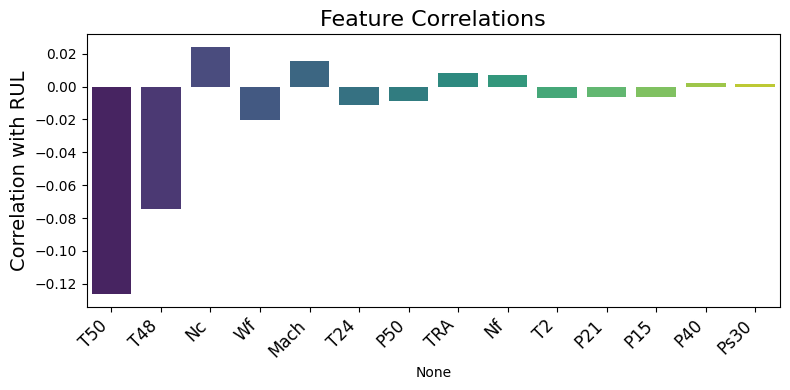

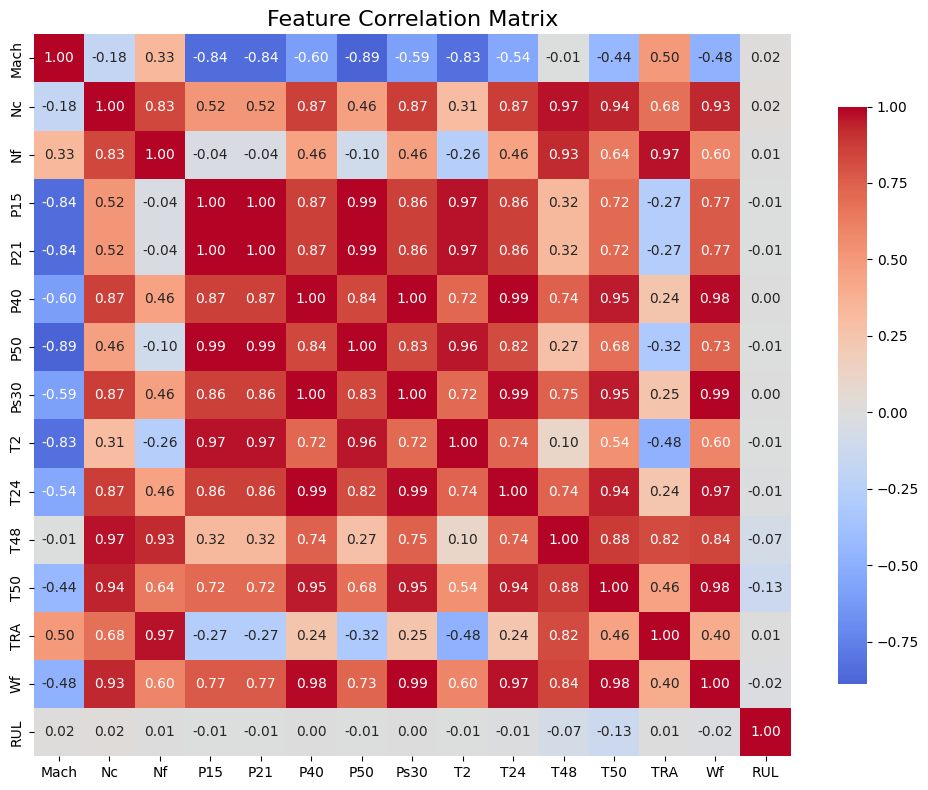

In [80]:
import seaborn as sns

fcols = feature_cols
corr = df_dev[fcols + ["RUL"]].corr()["RUL"].drop("RUL")
corr = corr.reindex(corr.abs().sort_values(ascending=False).index)

plt.figure(figsize=(8, 4))
sns.barplot(x=corr.index, y=corr.values, palette="viridis")
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.ylabel("Correlation with RUL", fontsize=14)
plt.title("Feature Correlations", fontsize=16)
plt.tight_layout()
plt.show()

fcols = feature_cols + ["RUL"]
corr = df_dev[fcols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"shrink": .8}, center=0)
plt.title("Feature Correlation Matrix", fontsize=16)
plt.tight_layout()
plt.show()

## Feature standardization

**Point**:
- Fit `Standard Scaler` on training split
- Apply the same transformation to validation and test splits

**Steps**:
- `scaler.fit()`
- Transform each split
` Extract the numpy arrays:
    - `X_train, y_train`
    - `X_val, yval`
    - `X_test, y_test`

In [81]:
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
scaler.fit(train_df[feature_cols].values)

def transformdf(df):

    X = scaler.transform(df[feature_cols].values)
    df_new = df.copy()
    df_new[feature_cols] = X
    return df_new

train_df = transformdf(train_df)
val_df   = transformdf(val_df)
test_df  = transformdf(test_df)

X_train = train_df[feature_cols].values
y_train = train_df["RUL"].values
X_val   = val_df[feature_cols].values
y_val   = val_df["RUL"].values
X_test  = test_df[feature_cols].values
y_test  = test_df["RUL"].values


In [82]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.optim import Adam
import math
import numpy as np
import matplotlib.pyplot as plt

## Sliding window construction 

To train, convert each engines time series into fixed-length input windows

**Idea**
For each engineid, sort by cycle and build sequences of length `W` (30 in this case)
Each training example uses previous `W` timesteps to predict current RUL

**Implementation**
- Group DF by engine id
- For each engine:
    - extract feature matrix and target vector
    - Sliding window from `i = W` to end
    - add to features and targets
- Engines shorter than window-length skipped

**outputs**
- `X_train_seq, y_train_seq`, `X_val_seq, y_val_seq`, `X_test_seq, y_test_seq`

In [83]:
def sliding_window_make_sequence(df, feature_cols, target_col="RUL", window = 30, id_col = "engine_id"):
    
    x_sequences = []
    y_sequences = []
    g_sequences = []

    for engineid, group in df.groupby(id_col):
        
        group = group.sort_values(["cycle", "_t_in_cycle"])
        features = group[feature_cols].values.astype(np.float32)
        targets = group[target_col].values.astype(np.float32)

        if len(group) <= window:
            continue

        for i in range(window, len(group)):
            x_sequences.append(features[i-window:i])
            y_sequences.append(targets[i])
            g_sequences.append(engineid)
        
    return np.stack(x_sequences), np.array(y_sequences), np.array(g_sequences)

window_size = 30
X_train_seq, y_train_seq, g_train_seq = sliding_window_make_sequence(train_df, feature_cols, window=window_size)
X_val_seq, y_val_seq, g_val_seq     = sliding_window_make_sequence(val_df, feature_cols, window=window_size)
X_test_seq, y_test_seq, g_test_seq   = sliding_window_make_sequence(test_df, feature_cols, window=window_size)


In [84]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126
import torch

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


Looking in indexes: https://download.pytorch.org/whl/cu126
Note: you may need to restart the kernel to use updated packages.
CUDA available: True
GPU: NVIDIA RTX A500 Laptop GPU


## Pytorch dataset and dataloaders

Wrap the sliding windows in `Dataset` and use `DataLoader` to feed the model batches

**Device**
- Uses GPU if availbale 

**RULSequenceDataset**
- Stores `X`, sequence ipnuts as tensors
- Stores `y`, RUL targets as tensors 

**DataLoaders**
- Create loaders for train/test/val
    - Each has `batch_size` 1024, `shuffle` True 

torch.backends.cudnn.benchmark allows further optimization of kernels when input shapes are consistent (speed up training)

In [85]:
from torch.utils.data import Dataset, DataLoader
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class RULSequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32)).unsqueeze(1)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = RULSequenceDataset(X_train_seq, y_train_seq)
val_dataset   = RULSequenceDataset(X_val_seq, y_val_seq)
test_dataset  = RULSequenceDataset(X_test_seq, y_test_seq)

batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)

print(len(train_dataset), len(val_dataset), len(test_dataset))

torch.backends.cudnn.benchmark = True

Using device: cuda
3545321 952681 765265


## GRU Regressor

Model the RUL using a Gated Recurrent Neural Network due to the fact that the data is time series 

**Architecture**:
- GRU Encoder processes an input sequence of shape (batch, W, F)
- `F = ipnut_dim` features per timeset
- `hidden_dim` is the number of hidden units/nodes
- `num layers` of stacked GRU layers
- Bidirectional GRU

**Foward Pass**
1. Run sequence through GRU
2. Take the final hidden state
3. Apply a fully-connected layer to output predicted RUL

- Returns the yhat for the regression

In [86]:
import torch.nn as nn

class GRURULModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1, bidirectional=False, dropout=0.0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_dir = 2 if bidirectional else 1
        
        self.gru = nn.GRU(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers,
                          batch_first=True, bidirectional=bidirectional, dropout=dropout if num_layers > 1 else 0.0)
        self.fc = nn.Linear(self.num_dir * hidden_dim, 1)

    def forward(self, x):
        out, temp = self.gru(x)
        last = temp[-1]
        yhat = self.fc(last)
        return yhat


## Training + Eval

Defines the training and evaluatoin for the GRU regressor

### Loss function:
We train using **MSE**

### Metrics
- Copmute **MSE** and **RMSE**
- Compute **MAE**
- Compute **NASA asymmetric score** that penalizes under/over prediction

### Nasa score

Let $d_i = y_i - \hat{y}_i$.

$$
\begin{aligned}
\alpha_i &=
\begin{cases}
\frac{1}{13}, & d_i > 0 \\
\frac{1}{10}, & d_i \le 0
\end{cases}
\\[6pt]
S &= \sum_{i=1}^{N} \exp\!\left(\alpha_i \, |d_i|\right)
\end{aligned}
$$


### Functions
- `train one epoch` runs one full training epoch of forward -> loss -> backward -> step
- `evaluate model` runs inference and returns metrics on the evaluated model


In [87]:
from torch.optim import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import copy

criterion = nn.MSELoss()

def train_one_epoch(dataloader, model, optimizer):

    model.train()
    se_sum = 0.0
    nasa_sum = 0.0
    numsamples = 0

    for Xbatch, ybatch in dataloader:
        Xbatch = Xbatch.to(device, non_blocking=True)
        ybatch = ybatch.to(device, non_blocking=True)
             
        optimizer.zero_grad()

        ypred = model(Xbatch)
        loss = criterion(ypred, ybatch)
        
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            diff = (ybatch - ypred).view(-1)
            se_sum += (diff ** 2).sum().item()
            numsamples += diff.numel()

            alpha = torch.where(diff > 0, 
                                torch.full_like(diff, 1.0/13.0), 
                                torch.full_like(diff, 1.0/10.0))
            
            nasa_sum += torch.exp(alpha * diff.abs()).sum().item()

    mse = se_sum/numsamples
    rmse = math.sqrt(mse)    
    return mse, rmse, nasa_sum

def evaluate_model(dataloader, model):

    model.eval()
    sesum = 0.0
    ae_sum = 0.0
    nasa_sum = 0.0
    numsamples = 0

    with torch.no_grad():
        for Xbatch, ybatch in dataloader:
            Xbatch = Xbatch.to(device, non_blocking=True)
            ybatch = ybatch.to(device, non_blocking=True)

            ypred = model(Xbatch)
            diff = (ybatch - ypred).view(-1)
    
            sesum += (diff ** 2).sum().item()
            ae_sum += diff.abs().sum().item()
            numsamples += diff.numel()

            alpha = torch.where(diff > 0,
                                torch.full_like(diff, 1.0/13.0),
                                torch.full_like(diff, 1.0/10.0))
            nasa_sum += torch.exp(alpha * diff.abs()).sum().item()

    mse = sesum/numsamples
    rmse = math.sqrt(sesum / numsamples)
    mae = ae_sum/numsamples
    return mse, rmse, mae, nasa_sum 

def evaluate_rmse_mae(loader, model):
    model.eval()
    se_sum = 0.0
    ae_sum = 0.0
    numsamples = 0

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device, non_blocking=True)
            y_batch = y_batch.to(device, non_blocking=True)
            y_pred = model(X_batch)
            
            se_sum += ((y_pred - y_batch) ** 2).sum().item()
            ae_sum += (y_pred-y_batch).abs().sum().item()
            numsamples += y_batch.numel()

    mse = se_sum / numsamples
    mae = ae_sum / numsamples
    rmse = math.sqrt(mse)
    return mse, rmse, mae


## Hyperparameter Tuning (Optuna + 3-fold CV)

To select good GRU hyperparams, we run **Optuna** with a **3-fold cross-validation** on a random subset of the training subseq

### Tuning
- Use a subset of the training for speed:
- Cross validation:
    - `kfolds` = 3 using `KFold` from sklearn
- Max epochs = 12 and a batch size of 512
- Minimize the mean best fold RMSE across the folds

### Search space
Optuna:
- `Explores hidden dimensions`
- `num layers`
- `dropout`
- `lr`

Per fold:
1. Train GRU model on training subset
2. Evaluate RMSE on the fold's validation 
3. Keep best validation RMSE achieved 
The trail score = average of best RMSE values across folds

Prunes to further aid with computation

### Final Model
After optimizing over 12 trials, 
- print best trial
- rebuild GRU with new optimized parameters
- initialize the Adam optimizer using the tuned lr

In [94]:

from sklearn.model_selection import GroupKFold
import optuna
import pandas as pd

tune_frac = 0.15
numtotal = len(X_train_seq)
numtune = int(tune_frac * numtotal)

randomstate = np.random.RandomState(42)
tune_idxs = randomstate.choice(numtotal, size = numtune, replace = False)
X_tune = X_train_seq[tune_idxs]
y_tune = y_train_seq[tune_idxs]
g_tune = g_train_seq[tune_idxs]



tuned_dataset = RULSequenceDataset(X_tune, y_tune)
print(f"Tuning on subset: {len(tuned_dataset)} out of {numtotal}")

def objective(trial):

    hidden_dim = trial.suggest_categorical("hidden_dim", [32, 64, 128])
    num_layers = trial.suggest_int("num_layers", 1, 2)
    dropout = trial.suggest_float("dropout", 0.0, 0.4)
    lr = trial.suggest_float("lr", 1e-4, 3e-3, log=True)

    k_folds = 3
    max_epochs = 12
    batch_size_obj = 512

    gkf = GroupKFold(n_splits= k_folds)
    fold_rmse = []
    all_idxs = np.arange(len(tuned_dataset))

    for fold, (train_idx, val_idx) in enumerate(gkf.split(all_idxs, groups=g_tune), start=1):
        train_subset = torch.utils.data.Subset(tuned_dataset, train_idx)
        val_subset   = torch.utils.data.Subset(tuned_dataset, val_idx)

        train_loader_cv = DataLoader(
            train_subset, batch_size=batch_size_obj, shuffle=True,
            num_workers=0, pin_memory=False
        )
        val_loader_cv = DataLoader(
            val_subset, batch_size=batch_size_obj, shuffle=False,
            num_workers=0, pin_memory=False
        )

        input_dim_cv = X_train_seq.shape[2]
        model_cv = GRURULModel(
            input_dim=input_dim_cv,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            bidirectional=False,
            dropout=dropout
        ).to(device)

        optimizer_cv = Adam(model_cv.parameters(), lr=lr)

        best_fold_rmse = float("inf")

        for epoch in range(1, max_epochs + 1):
            train_mse, train_rmse, _ = train_one_epoch(train_loader_cv, model_cv, optimizer_cv)
            val_mse, val_rmse, val_mae, val_nasa = evaluate_model(val_loader_cv, model_cv)

            if val_rmse < best_fold_rmse:
                best_fold_rmse = val_rmse

        fold_rmse.append(best_fold_rmse)

        # Optional: early prune bad trials
        trial.report(best_fold_rmse, fold)
        if trial.should_prune():
            raise optuna.TrialPruned()

    mean_rmse = float(np.mean(fold_rmse))
    return mean_rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=12) 

print("=== Optuna best trial ===")
print("Trial number:", study.best_trial.number)
print("Best RMSE:", study.best_value)
print("Best params:", study.best_params)

best_params = study.best_params

best_hidden= int(best_params["hidden_dim"])
best_layers = int(best_params["num_layers"])
best_dropout= float(best_params["dropout"])
best_lr = float(best_params["lr"])

input_dim = X_train_seq.shape[2]

model = GRURULModel(
    input_dim=input_dim,
    hidden_dim=best_hidden,
    num_layers=best_layers,
    bidirectional=False,
    dropout=best_dropout
).to(device)

optimizer = Adam(model.parameters(), lr=best_lr)

print("\nFinal model for full training with tuned hyperparameters:")
print(model)
print("Using learning rate:", best_lr)


[I 2025-12-12 16:00:19,588] A new study created in memory with name: no-name-cd947add-c8b4-4c9f-8ac4-e45c223ea970


Tuning on subset: 531798 out of 3545321


[I 2025-12-12 16:06:49,764] Trial 0 finished with value: 8.15558116609049 and parameters: {'hidden_dim': 128, 'num_layers': 1, 'dropout': 0.2574669034793157, 'lr': 0.0020535705161799657}. Best is trial 0 with value: 8.15558116609049.
[I 2025-12-12 16:13:24,719] Trial 1 finished with value: 8.068078667375577 and parameters: {'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.015923696570693036, 'lr': 0.0009508345349674684}. Best is trial 1 with value: 8.068078667375577.
[I 2025-12-12 16:16:45,231] Trial 2 finished with value: 12.257444438028855 and parameters: {'hidden_dim': 32, 'num_layers': 1, 'dropout': 0.048671870537771604, 'lr': 0.0003152732323397904}. Best is trial 1 with value: 8.068078667375577.
[I 2025-12-12 16:22:32,165] Trial 3 finished with value: 7.807325302733735 and parameters: {'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.17738821981926814, 'lr': 0.00023322255816125108}. Best is trial 3 with value: 7.807325302733735.
[I 2025-12-12 16:27:56,332] Trial 4 finished with valu

=== Optuna best trial ===
Trial number: 11
Best RMSE: 7.083319858192262
Best params: {'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.3267118388212307, 'lr': 0.00043305888493568604}

Final model for full training with tuned hyperparameters:
GRURULModel(
  (gru): GRU(14, 64, num_layers=2, batch_first=True, dropout=0.3267118388212307)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
Using learning rate: 0.00043305888493568604


## Final training loop

We finally train the GRU for a fixed number of epochs while tracking the performance on validation set

**Training config**
- `num_ephocs` 80
- Validation computed every 5 epochs to reduce overhead

**Model selection**
- After each validation check, compare current **val RMSE** to best seen so far
- If improved, deep copy the current model weights into a `model`

**Final evaluatoin**
- Using best model, evaluate **test_set** and report the metrics


In [95]:
num_epochs = 80
val_every = 5  # not computing val every time for speed

best_val_rmse = float('inf')
best_model_state = None

for epoch in range(1, num_epochs + 1):
    train_mse, train_rmse, train_nasa = train_one_epoch(train_loader, model, optimizer)

    if epoch % val_every == 0 or epoch == 1:
        val_mse, val_rmse, val_mae, val_nasa = evaluate_model(val_loader, model)

        print(f"Epoch {epoch}/{num_epochs}")
        print(f"  TRAIN - MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, NASA s: {train_nasa:.4f}")
        print(f"  VAL   - MSE: {val_mse:.4f}, RMSE: {val_rmse:.4f}, "
              f"MAE: {val_mae:.4f}, NASA s: {val_nasa:.4f}")

        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_model_state = copy.deepcopy(model.state_dict())
    else:
        print(f"Epoch {epoch}/{num_epochs}")
        print(f"  TRAIN - MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, NASA s: {train_nasa:.4f}")

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Loaded best model with best VAL RMSE:", best_val_rmse)

# Final test evaluation
test_mse, test_rmse, test_mae, test_nasa = evaluate_model(test_loader, model)
print(f"TEST  - MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, "
      f"MAE: {test_mae:.4f}, NASA s: {test_nasa:.4f}")

Epoch 1/80
  TRAIN - MSE: 540.9586, RMSE: 23.2585, NASA s: 39006329.6155
  VAL   - MSE: 75.9120, RMSE: 8.7127, MAE: 5.5503, NASA s: 1740698.0823
Epoch 2/80
  TRAIN - MSE: 48.2944, RMSE: 6.9494, NASA s: 6047505.6946
Epoch 3/80
  TRAIN - MSE: 43.5615, RMSE: 6.6001, NASA s: 5910260.9800
Epoch 4/80
  TRAIN - MSE: 42.5610, RMSE: 6.5239, NASA s: 5863071.1904
Epoch 5/80
  TRAIN - MSE: 41.4488, RMSE: 6.4381, NASA s: 5810703.2172
  VAL   - MSE: 42.4055, RMSE: 6.5120, MAE: 4.6232, NASA s: 1465658.7377
Epoch 6/80
  TRAIN - MSE: 40.1260, RMSE: 6.3345, NASA s: 5747047.4730
Epoch 7/80
  TRAIN - MSE: 38.4400, RMSE: 6.2000, NASA s: 5672455.1896
Epoch 8/80
  TRAIN - MSE: 36.8819, RMSE: 6.0731, NASA s: 5606781.4695
Epoch 9/80
  TRAIN - MSE: 35.8715, RMSE: 5.9893, NASA s: 5560779.0518
Epoch 10/80
  TRAIN - MSE: 34.6527, RMSE: 5.8867, NASA s: 5506569.7059
  VAL   - MSE: 50.6636, RMSE: 7.1178, MAE: 4.8352, NASA s: 1530266.7979
Epoch 11/80
  TRAIN - MSE: 33.2851, RMSE: 5.7693, NASA s: 5446895.2437
Epoch 12/

KeyboardInterrupt: 

## Preds and tolerance based accuracy

Compute standard regression metrics and compute how often model predicts RUL within a fixed error tolerance


In [ ]:
def get_preds(loader, model):

    model.eval()
    preds = []
    trues = []

    with torch.no_grad():
        for X_batch, Y_batch in loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            y_pred = model(X_batch)
            preds.append(y_pred.cpu().numpy())
            trues.append(Y_batch.cpu().numpy())
    
    preds = np.vstack(preds).ravel()
    trues = np.vstack(trues).ravel()
    return trues, preds

train_mse, train_rmse, train_mae, train_nasa = evaluate_model(train_loader, model)
test_mse, test_rmse, test_mae, test_nasa = evaluate_model(test_loader, model)

y_true_train, y_pred_train = get_preds(train_loader, model)
y_true_test, y_pred_test = get_preds(test_loader, model)


def accuracy_within_tolerance(y_true, y_pred, tol=10.0):
    """
    Returns percentage of predictions whose absolute error is <= tol.
    """
    diff = np.abs(y_true - y_pred)
    return (diff <= tol).mean() * 100.0

# Example: accuracy within 5 and 10 cycles on test set
acc5_test  = accuracy_within_tolerance(y_true_test, y_pred_test, tol=5.0)
acc10_test = accuracy_within_tolerance(y_true_test, y_pred_test, tol=10.0)

print(f"Test accuracy (|error| <= 5 cycles):  {acc5_test:.2f}%")
print(f"Test accuracy (|error| <= 10 cycles): {acc10_test:.2f}%")

# (Optional) same for training set
acc5_train  = accuracy_within_tolerance(y_true_train, y_pred_train, tol=5.0)
acc10_train = accuracy_within_tolerance(y_true_train, y_pred_train, tol=10.0)

print(f"Train accuracy (|error| <= 5 cycles):  {acc5_train:.2f}%")
print(f"Train accuracy (|error| <= 10 cycles): {acc10_train:.2f}%")


Test accuracy (|error| <= 5 cycles):  74.17%
Test accuracy (|error| <= 10 cycles): 94.06%
Train accuracy (|error| <= 5 cycles):  69.29%
Train accuracy (|error| <= 10 cycles): 87.23%


In [ ]:


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

def plot_results_dashboard(
    y_true_train, y_pred_train,
    y_true_test,  y_pred_test,
    train_mse, train_rmse, train_mae, train_nasa,
    test_mse,  test_rmse,  test_mae,  test_nasa,
    dataset_name="N-CMAPSS_DS02-006.h5",
    window_size=30,
    n_selected_features=None,
    n_window_features=None
):
    fig = plt.figure(figsize=(16, 9))
    gs = gridspec.GridSpec(3, 3, figure=fig)
    
    ax_text = fig.add_subplot(gs[0, 0])
    ax_text.axis("off")
    
    lines = [
        "ADVANCED: RESULTS",
        "",
        f"Dataset: {dataset_name}",
        f"Window Size: {window_size}",
    ]
    if n_selected_features is not None:
        lines.append(f"Selected Features: {n_selected_features}")
    if n_window_features is not None:
        lines.append(f"Window Features: {n_window_features}")
    lines.append("")
    lines.append("Training Set:")
    lines.append(f"  MSE:   {train_mse:.4f}")
    lines.append(f"  RMSE:  {train_rmse:.4f}")
    lines.append(f"  MAE:   {train_mae:.4f}")
    lines.append(f"  NASA:  {train_nasa:.2f}")
    lines.append("")
    lines.append("Test Set:")
    lines.append(f"  MSE:   {test_mse:.4f}")
    lines.append(f"  RMSE:  {test_rmse:.4f}")
    lines.append(f"  MAE:   {test_mae:.4f}")
    lines.append(f"  NASA:  {test_nasa:.2f}")
    
    ax_text.text(
        0.0, 1.0,
        "\n".join(lines),
        va="top", ha="left",
        fontsize=10,
    )
    
    ax1 = fig.add_subplot(gs[0, 1])
    ax1.scatter(y_true_train, y_pred_train, alpha=0.3)
    min_val = min(y_true_train.min(), y_pred_train.min())
    max_val = max(y_true_train.max(), y_pred_train.max())
    ax1.plot([min_val, max_val], [min_val, max_val], "r--", linewidth=2)
    ax1.set_xlabel("True RUL Values")
    ax1.set_ylabel("Predicted RUL Values")
    ax1.set_title("True vs. Predicted RUL: Training Data")
    
    ax2 = fig.add_subplot(gs[0, 2])
    ax2.scatter(y_true_test, y_pred_test, alpha=0.3)
    min_val = min(y_true_test.min(), y_pred_test.min())
    max_val = max(y_true_test.max(), y_pred_test.max())
    ax2.plot([min_val, max_val], [min_val, max_val], "r--", linewidth=2)
    ax2.set_xlabel("True RUL Values")
    ax2.set_ylabel("Predicted RUL Values")
    ax2.set_title("True vs. Predicted RUL: Test Data")
    
    train_resid = y_true_train - y_pred_train
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.hist(train_resid, bins=40)
    ax3.set_title("Actual - Predicted Difference: Training Data")
    ax3.set_xlabel("Actual - Predicted")
    ax3.set_ylabel("Frequency")
    
    test_resid = y_true_test - y_pred_test
    ax4 = fig.add_subplot(gs[1, 2])
    ax4.hist(test_resid, bins=40)
    ax4.set_title("Actual - Predicted Difference: Test Data")
    ax4.set_xlabel("Actual - Predicted")
    ax4.set_ylabel("Frequency")

    ax5 = fig.add_subplot(gs[2, 0])
    ax5.bar(["Training", "Testing"], [train_mse, test_mse])
    ax5.set_title("Mean Squared Error")

    ax6 = fig.add_subplot(gs[2, 1])
    ax6.bar(["Training", "Testing"], [train_rmse, test_rmse])
    ax6.set_title("Root Mean Squared Error")

    ax7 = fig.add_subplot(gs[2, 2])
    ax7.bar(["Training", "Testing"], [train_mae, test_mae])
    ax7.set_title("Mean Absolute Error")
    
    fig.tight_layout()
    plt.show()


plot_results_dashboard(
    y_true_train, y_pred_train,
    y_true_test,  y_pred_test,
    train_mse, train_rmse, train_mae, train_nasa,
    test_mse,  test_rmse,  test_mae,  test_nasa,
    dataset_name="N-CMAPSS_DS02-006.h5",
    window_size=window_size,
    n_selected_features=len(feature_cols),
    n_window_features=X_train_seq.shape[1] * X_train_seq.shape[2] 
)





NameError: name 'y_true_train' is not defined

In [96]:
import copy
import torch
from torch.optim import Adam

base_hidden = 64
base_layers = 1
base_dropout = 0.0
base_lr = 1e-3
base_bidir = False

input_dim = X_train_seq.shape[2]

baseline_model = GRURULModel(
    input_dim=input_dim,
    hidden_dim=base_hidden,
    num_layers=base_layers,
    bidirectional=base_bidir,
    dropout=base_dropout,
).to(device)

base_optim = Adam(baseline_model.parameters(), lr=base_lr)

num_epochs = 80
val_every = 5
best_val_rmse = float("inf")
best_state = None

for epoch in range(1, num_epochs + 1):
    train_mse, train_rmse, train_nasa = train_one_epoch(train_loader, baseline_model, base_optim)

    if epoch % val_every == 0 or epoch == 1:
        val_mse, val_rmse, val_mae, val_nasa = evaluate_model(val_loader, baseline_model)

        print(f"Epoch {epoch}/{num_epochs}")
        print(f"TraIAn-MSE:{train_mse:.4f} RMSE:{train_rmse:.4f} NASA:{train_nasa:.4f}")
        print(f"val-MSE:{val_mse:.4f} RMSE:{val_rmse:.4f} MAE:{val_mae:.4f} NASA:{val_nasa:.4f}")

        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_state = copy.deepcopy(baseline_model.state_dict())
    else:
        print(f"Epoch {epoch}/{num_epochs}")
        print(f"train-MSE:{train_mse:.4f} RMSE:{train_rmse:.4f} NASA:{train_nasa:.4f}")

if best_state is not None:
    baseline_model.load_state_dict(best_state)
    print(f"Loaded best baseline VAL-RMSE:{best_val_rmse:.4f}")

base_train_mse, base_train_rmse, base_train_mae, base_train_nasa = evaluate_model(train_loader, baseline_model)
base_test_mse, base_test_rmse, base_test_mae, base_test_nasa = evaluate_model(test_loader, baseline_model)

print(f"BASELINE-TEST MSE:{base_test_mse:.4f} RMSE:{base_test_rmse:.4f} MAE:{base_test_mae:.4f} NASA:{base_test_nasa:.4f}")

y_true_train_b, y_pred_train_b = get_preds(train_loader, baseline_model)
y_true_test_b, y_pred_test_b = get_preds(test_loader, baseline_model)

plot_results_dashboard(
    y_true_train_b, y_pred_train_b,
    y_true_test_b, y_pred_test_b,
    base_train_mse, base_train_rmse, base_train_mae, base_train_nasa,
    base_test_mse, base_test_rmse, base_test_mae, base_test_nasa,
    dataset_name="N-CMAPSS_DS02-006.h5",
    window_size=window_size,
    n_selected_features=len(feature_cols),
    n_window_features=X_train_seq.shape[1] * X_train_seq.shape[2],
)


KeyboardInterrupt: 

LR-SWEEP train_windows:3545321 train_eng:4 val_windows:952681 val_eng:1
LR-SWEEP lr:1.0e-05 best_val_rmse:23.2506
LR-SWEEP lr:3.0e-05 best_val_rmse:8.9042
LR-SWEEP lr:1.0e-04 best_val_rmse:5.6371
LR-SWEEP lr:3.0e-04 best_val_rmse:6.0886
LR-SWEEP lr:1.0e-03 best_val_rmse:6.9273
LR-SWEEP lr:3.0e-03 best_val_rmse:6.6418


,lr,best_val_rmse
0,0.00001,23.250556
1,0.00003,8.904231
2,0.00010,5.637109
3,0.00030,6.088626
4,0.00100,6.927268
5,0.00300,6.641758


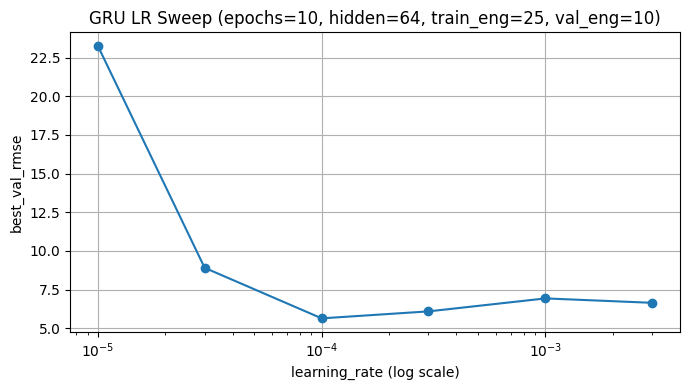

In [97]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
import matplotlib.pyplot as plt
import pandas as pd

def subset_by_engines(X, y, g, n_engines, seed=42):
    rng = np.random.RandomState(seed)
    unique_eng = np.unique(g)
    chosen = rng.choice(unique_eng, size=min(n_engines, len(unique_eng)), replace=False)
    mask = np.isin(g, chosen)
    return X[mask], y[mask], g[mask], chosen

N_TRAIN_ENG_SMALL = 25
N_VAL_ENG_SMALL = 10

X_train_small, y_train_small, g_train_small, train_engs = subset_by_engines(
    X_train_seq, y_train_seq, g_train_seq, n_engines=N_TRAIN_ENG_SMALL, seed=42
)
X_val_small, y_val_small, g_val_small, val_engs = subset_by_engines(
    X_val_seq, y_val_seq, g_val_seq, n_engines=N_VAL_ENG_SMALL, seed=123
)

train_small_ds = RULSequenceDataset(X_train_small, y_train_small)
val_small_ds = RULSequenceDataset(X_val_small, y_val_small)

batch_size = 512
train_small_loader = DataLoader(train_small_ds, batch_size=batch_size, shuffle=True, num_workers=0)
val_small_loader = DataLoader(val_small_ds, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"LR-SWEEP train_windows:{len(train_small_ds)} train_eng:{len(train_engs)} val_windows:{len(val_small_ds)} val_eng:{len(val_engs)}")

hidden_dim = 64
num_layers = 1
dropout = 0.0
bidirectional = False
epochs_sweep = 10

lrs = [1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3]
results = []
input_dim = X_train_seq.shape[2]

for lr in lrs:
    model_sweep = GRURULModel(
        input_dim=input_dim,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        bidirectional=bidirectional,
        dropout=dropout,
    ).to(device)

    opt = Adam(model_sweep.parameters(), lr=lr)
    best_val_rmse = float("inf")

    for _ in range(epochs_sweep):
        train_one_epoch(train_small_loader, model_sweep, opt)
        _, val_rmse, _, _ = evaluate_model(val_small_loader, model_sweep)
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse

    results.append({"lr": lr, "best_val_rmse": best_val_rmse})
    print(f"LR-SWEEP lr:{lr:.1e} best_val_rmse:{best_val_rmse:.4f}")

results_df = pd.DataFrame(results).sort_values("lr").reset_index(drop=True)
display(results_df)

plt.figure(figsize=(7, 4))
plt.plot(results_df["lr"], results_df["best_val_rmse"], marker="o")
plt.xscale("log")
plt.xlabel("learning_rate (log scale)")
plt.ylabel("best_val_rmse")
plt.title(f"GRU LR Sweep (epochs={epochs_sweep}, hidden={hidden_dim}, train_eng={N_TRAIN_ENG_SMALL}, val_eng={N_VAL_ENG_SMALL})")
plt.grid(True)
plt.tight_layout()
plt.show()
